In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

# Math Stuff
import scipy.misc, random, os
import numpy as np

# Google Earth Engine
import ee
from gee_library import *
ee.Initialize()

# debug stuff
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Threads
import time, Queue
from threading import Thread

# Tensorflow
import tensorflow as tf


In [2]:
# Each element of img_queue will be a dictionary in the form {'band': numpy_array}
img_queue = Queue.Queue()


#
# Download worker
#
def imagery_getter(label, geCollection, meters, pixels, bands, coords):
    """
    Downloads imagery and decodes into numpy data; adds the matrix data to img_queue.
    
    geCollection: ee.ImageCollection object
    meters: Each image will depict and area measuring meters x meters 
    pixels: Each image will measure pixels x pixels
    bands: dictionary of band names. Example: ['R', 'G', 'B']
    coords: Two gps points describing a rectangle in the form:
    ((longitude_min, latitude_min),(longitude_max, latitude_max))
    """
    try:
        # Get random location in box
        ((longmin, latmin),(longmax, latmax)) = coords

        # get random coords
        longitude = random.uniform(longmin, longmax)
        latitude = random.uniform(latmin, latmax)

        # Calculate resolution
        resolution = meters/pixels

        # Build the GPS box Geometry object
        tile_bounds = square_centered_at(
            point = (longitude, latitude),
            half_distance = meters / 2
        )

        # request imagery
        tiles = img_at_region(geCollection, resolution, bands, tile_bounds)

        # Add tiles to queue for writing
        imagery_item = {'label': label,
                        'R': scipy.misc.imresize(tiles['R'], (pixels, pixels)),
                        'G': scipy.misc.imresize(tiles['G'], (pixels, pixels)),
                        'B': scipy.misc.imresize(tiles['B'], (pixels, pixels))}
        img_queue.put(imagery_item)
        
    #
    # Error Handling
    #
    except ServerError as e:
        print e, coords
    except Exception as e:
        print e, coords
    return
    

#
# Protobuf creator worker
#
def proto_writer_worker(PROTO_FILENAME):
    
    print "Started protobuf writer."

    # Open a protobuffer writer
    proto_writer = tf.python_io.TFRecordWriter(PROTO_FILENAME)


    # Consume things from the queue.
    try: 
        while True:
            
            # Consume one item from the queue. Raise exception if empty for 60 seconds
            example = img_queue.get(block=True, timeout=60)
            
            R = example['R'].flatten()
            G = example['G'].flatten()
            B = example['B'].flatten()
            label=example['label']

            proto_example = tf.train.Example(
                features=tf.train.Features( # a map of string to Feature proto objects
                    feature={
                        # A Feature contains one of either a int64_list,
                        # float_list, or bytes_list
                        'label': tf.train.Feature(
                            int64_list=tf.train.Int64List(value=[int(label)])),
                        'R': tf.train.Feature(
                            int64_list=tf.train.Int64List(value=R.astype("int64"))),
                        'G': tf.train.Feature(
                            int64_list=tf.train.Int64List(value=G.astype("int64"))),
                        'B': tf.train.Feature(
                            int64_list=tf.train.Int64List(value=B.astype("int64"))),
                    }
                )
            )

            # use the proto object to serialize the example to a string
            serialized = proto_example.SerializeToString()
            # write the serialized object to disk
            proto_writer.write(serialized)
            
            print "Wrote something."
            
    except Queue.Empty:
        print "Queue empty. Protobuf worker stopped."

In [3]:
PROTO_FILENAME = "multi_spectrum.tf"
threads = []

#
# Start writer worker
#
t = Thread(target=proto_writer_worker, args=[PROTO_FILENAME])
t.start()
threads.append(t)

#
# Start downloader workers
#
geCollection=ee.ImageCollection('USDA/NAIP/DOQQ')
label = 1
meters = 2000
pixels = 25
bands = ['R', 'G', 'B']
coords = ((-110.042831, 43.716602), (-109.379713, 44.437358))

for i in range(5):
    print i
    t = Thread(target=imagery_getter,
               args=(label, geCollection, meters, pixels, bands, coords))
    t.start()
    threads.append(t)
    time.sleep(2)

# wait for all threads to finish
for t in threads:
    t.join()

Started protobuf writer.
0
1
2
3
Wrote something.
4
Wrote something.
Wrote something.
Wrote something.
Wrote something.
Queue empty. Protobuf worker stopped.


(25, 25, 3)
1


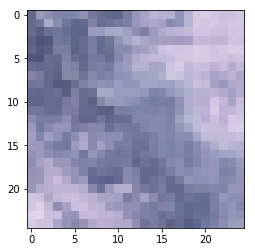

(25, 25, 3)
1


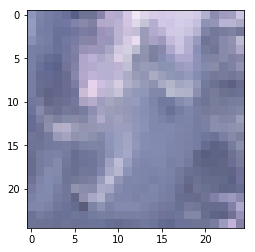

(25, 25, 3)
1


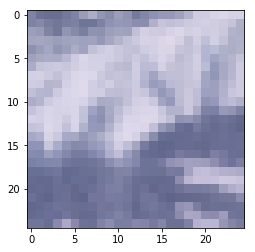

In [8]:
#
# Look inside protobuff to make sure records are correctly recorded.
#

i = 0
for serialized_example in tf.python_io.tf_record_iterator(PROTO_FILENAME):
    i = i + 1
    if i > 3:
        break
    example = tf.train.Example()
    example.ParseFromString(serialized_example)

    # traverse the Example format to get data
    R = example.features.feature['R'].int64_list.value
    G = example.features.feature['G'].int64_list.value
    B = example.features.feature['B'].int64_list.value
    img = np.dstack([np.array(R).astype("float32").reshape((25,25)),
                     np.array(G).astype("float32").reshape((25,25)),
                     np.array(B).astype("float32").reshape((25,25))])
    print img.shape
    label = example.features.feature['label'].int64_list.value[0]
    # do something
    print label

    plt.imshow(img); plt.show()